In [1]:
!nvidia-smi

Sat Sep 25 18:29:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0    45W / 300W |     47MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [2]:
### https://ml-challenge.mercadolibre.com/
import pandas as pd
import cudf
import numpy as np
import gc
import xgboost as xgb 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    _ = gc.collect()
    return df

In [3]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

valid = train.loc[train.date >'2021-03-01'].copy()
gc.collect()

train = train.loc[train.date <= '2021-03-01'].copy()
gc.collect()

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

valid['dcount'] = valid.groupby('sku')['date'].transform('cumcount')
valid['dcount_max'] = valid.groupby('sku')['date'].transform('count')
valid['icount'] = valid['dcount_max'] - valid['dcount']-1
gc.collect()

del train['target_stock']
del valid['target_stock']

train.shape, valid.shape

(37660279, 20)


((18091368, 22), (19568911, 22))

In [4]:
train.columns

Index(['sku', 'date', 'sold_quantity', 'current_price', 'currency',
       'listing_type', 'shipping_logistic_type', 'shipping_payment',
       'minutes_active', 'month', 'dow', 'item_domain_id', 'item_id',
       'site_id', 'product_id', 'product_family_id', 'item_title_id',
       'item_title_0', 'item_title_1', 'dcount', 'dcount_max', 'icount'],
      dtype='object')

In [5]:
train.tail()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,item_id,site_id,product_id,product_family_id,item_title_id,item_title_0,item_title_1,dcount,dcount_max,icount
31651969,660915,2021-02-25,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,24,29,4
31651970,660915,2021-02-26,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,25,29,3
31651971,660915,2021-02-27,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,26,29,2
31651972,660915,2021-02-28,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,27,29,1
31651973,660915,2021-03-01,0,89.980003,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,28,29,0


In [6]:
valid.tail()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,item_id,site_id,product_id,product_family_id,item_title_id,item_title_0,item_title_1,dcount,dcount_max,icount
31651999,660915,2021-03-27,0,79.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,25,30,4
31652000,660915,2021-03-28,0,79.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,26,30,3
31652001,660915,2021-03-29,0,79.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,27,30,2
31652002,660915,2021-03-30,0,99.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,28,30,1
31652003,660915,2021-03-31,0,99.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,29,30,0


# Build local Validation

In [7]:
%%time
print(valid.shape)
valid['sum_sell'] = valid.groupby('sku')['sold_quantity'].transform('sum')
valid = valid.loc[(valid.dcount_max==30)&(valid.sum_sell>0)].copy()
print(valid.shape)
valid['cs_sell'] = valid.groupby('sku')['sold_quantity'].transform('cumsum')

dt = valid.loc[valid.sold_quantity>0].groupby('sku')['cs_sell'].apply(list).reset_index(name='sells')
np.random.seed(1)
dt['target_stock'] = dt['sells'].apply(lambda x: np.random.choice(x) )
del dt['sells']
dt

(19568911, 22)
(17303490, 23)
CPU times: user 29.3 s, sys: 1.8 s, total: 31.1 s
Wall time: 30.8 s


,sku,target_stock
0,0,11
1,1,15
2,3,1
3,4,2
4,5,12
...,...,...
576778,660911,11
576779,660912,3
576780,660913,2
576781,660914,3


In [8]:
#merge target_stock to train and validation
valid = valid.merge(dt[['sku', 'target_stock']], on='sku', how='left')
train = train.merge(dt[['sku', 'target_stock']], on='sku', how='left')

valid.target_stock.value_counts()

1        2244570
2        1863660
3        1601700
4        1378200
5        1181310
          ...   
1099          30
1098          30
1097          30
1095          30
30030         30
Name: target_stock, Length: 1344, dtype: int64

In [9]:
valid['target'] = 1 *(valid['cs_sell'] >= valid['target_stock'])
print( valid['target'].mean() )


ytrue = valid.pivot(index='sku', columns='dcount', values='target').reset_index()
ytrue = ytrue.reset_index(drop=True)
vals = ytrue.loc[:,range(30)].mean(0).values
vals[1:] = vals[1:] - vals[:-1]

valid['ypred'] = 1/30
VAL = valid.pivot(index='sku', columns='dcount', values='ypred').reset_index()
VAL = VAL.reset_index(drop=True)
VAL = VAL.fillna(1/30)
# for i in range(30):
#     VAL[i] = vals[i]
    
def metric( ytrue, ypred ):
    tmp = ypred.loc[:,range(30)].cumsum(1).values.copy()
    tmp[tmp>1] = 1
    tmp[tmp<0] = 0
    tmp /= tmp.max(1, keepdims=True)
    return np.sum( (ytrue.loc[:,range(30)].values - tmp)**2 ) / ytrue.shape[0]    

metric( ytrue, VAL )

0.5184950550438091


5.1984754231660775

In [10]:
def metric_at( ytrue, ypred, at=0 ):
    tmp = ypred.loc[:,range(30)].cumsum(1).values.copy()
    tmp[tmp>1] = 1
    tmp[tmp<0] = 0
    tmp /= tmp.max(1, keepdims=True)
    return np.mean( (ytrue.loc[:,at].values - tmp[:,at])**2 ) 

# Build Features

In [11]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1).fillna(0)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2).fillna(0)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3).fillna(0)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4).fillna(0)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5).fillna(0)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6).fillna(0)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7).fillna(0)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8).fillna(0)
train['sell_lag_9'] = train['sell_lag_8'] + train.groupby('sku')['sell_true'].shift(9).fillna(0)
train['sell_lag_10'] = train['sell_lag_9'] + train.groupby('sku')['sell_true'].shift(10).fillna(0)
train['sell_lag_11'] = train['sell_lag_10'] + train.groupby('sku')['sell_true'].shift(11).fillna(0)
train['sell_lag_12'] = train['sell_lag_11'] + train.groupby('sku')['sell_true'].shift(12).fillna(0)
train['sell_lag_13'] = train['sell_lag_12'] + train.groupby('sku')['sell_true'].shift(13).fillna(0)
train['sell_lag_14'] = train['sell_lag_13'] + train.groupby('sku')['sell_true'].shift(14).fillna(0)

train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(1)) #/ (train['current_price']+1)
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(2)) #/ (train['current_price']+1)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(3)) #/ (train['current_price']+1)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(4)) #/ (train['current_price']+1)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(5)) #/ (train['current_price']+1)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(6)) #/ (train['current_price']+1)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(7)) #/ (train['current_price']+1)

train['act_lag_1'] = train.groupby('sku')['minutes_active'].shift(1).bfill()
train['act_lag_2'] = train.groupby('sku')['minutes_active'].shift(2).bfill()
train['act_lag_3'] = train.groupby('sku')['minutes_active'].shift(3).bfill()
train['act_lag_4'] = train.groupby('sku')['minutes_active'].shift(4).bfill()
train['act_lag_5'] = train.groupby('sku')['minutes_active'].shift(5).bfill()
train['act_lag_6'] = train.groupby('sku')['minutes_active'].shift(6).bfill()
train['act_lag_7'] = train.groupby('sku')['minutes_active'].shift(7).bfill()

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1).bfill()

train['sold_quantity_log'] = np.log1p( train['sold_quantity'] )
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1).fillna(0)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2).fillna(0)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3).fillna(0)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4).fillna(0)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5).fillna(0)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6).fillna(0)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7).fillna(0)

CPU times: user 37.1 s, sys: 7.69 s, total: 44.8 s
Wall time: 44.8 s


# Build average sales in day 1 and 2 in future

<AxesSubplot:>

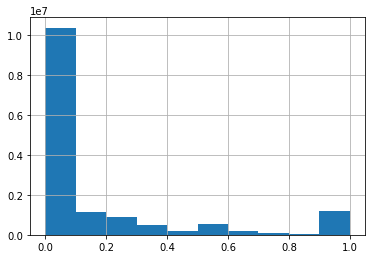

In [12]:
train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)
train['target0'] = train.groupby('sku')['target'].shift(-1)
train['target1'] = train.groupby('sku')['target'].shift(-2)
train['target'] = (train['target0'] + train['target1']).clip(0, 1)
train['target'].hist()

In [13]:
train.columns

Index(['sku', 'date', 'sold_quantity', 'current_price', 'currency',
       'listing_type', 'shipping_logistic_type', 'shipping_payment',
       'minutes_active', 'month', 'dow', 'item_domain_id', 'item_id',
       'site_id', 'product_id', 'product_family_id', 'item_title_id',
       'item_title_0', 'item_title_1', 'dcount', 'dcount_max', 'icount',
       'target_stock', 'sell_lag', 'sell_act', 'sell_true', 'sell_lag_1',
       'sell_lag_2', 'sell_lag_3', 'sell_lag_4', 'sell_lag_5', 'sell_lag_6',
       'sell_lag_7', 'sell_lag_8', 'sell_lag_9', 'sell_lag_10', 'sell_lag_11',
       'sell_lag_12', 'sell_lag_13', 'sell_lag_14', 'price_lag_1',
       'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5',
       'price_lag_6', 'price_lag_7', 'act_lag_1', 'act_lag_2', 'act_lag_3',
       'act_lag_4', 'act_lag_5', 'act_lag_6', 'act_lag_7',
       'shipping_logistic_type_lag_1', 'sold_quantity_log', 'sum_sells_1',
       'sum_sells_2', 'sum_sells_3', 'sum_sells_4', 'sum_sells_5',
       's

In [14]:
features = [
    'sold_quantity',
    'current_price',
    'shipping_logistic_type',
    'minutes_active',
    'item_domain_id',
    'item_id',
    'item_title_id',
    'target_stock',              
    'sell_lag', 'sell_act', 'sell_true', 
    'sell_lag_1', 'sell_lag_2', 'sell_lag_3', 'sell_lag_4', 'sell_lag_5', 'sell_lag_6', 'sell_lag_7', 'sell_lag_8', 'sell_lag_9', 'sell_lag_10', 'sell_lag_11', 'sell_lag_12', 'sell_lag_13', 'sell_lag_14',
    'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7',
    'act_lag_1', 'act_lag_2', 'act_lag_3', 'act_lag_4',
    'shipping_logistic_type_lag_1',
    'sold_quantity_log', 
    'sum_sells_1', 'sum_sells_2', 'sum_sells_3', 'sum_sells_4', 'sum_sells_5', 'sum_sells_6',
    'sold_lag_1', 'sold_lag_2', 'sold_lag_3', 'sold_lag_4', 'sold_lag_5', 'sold_lag_6', 'sold_lag_7'
           ]
train[features].head()

,sold_quantity,current_price,shipping_logistic_type,minutes_active,item_domain_id,item_id,item_title_id,target_stock,sell_lag,sell_act,...,sum_sells_4,sum_sells_5,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7
0,0,172.789993,1,0.000000,46,83220,79378,11.0,0.0,0.000000,...,176251.743502,0.000000,39.033102,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,172.789993,1,0.000000,46,83220,79378,11.0,0.0,0.000000,...,184917.319373,0.693147,22.159365,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,179.990005,1,872.650024,46,83220,79378,11.0,0.0,872.650024,...,190207.253350,1.791759,30.412593,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,179.990005,1,1440.000000,46,83220,79378,11.0,0.0,2312.649902,...,186399.494680,3.871201,35.235803,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,179.990005,1,1440.000000,46,83220,79378,11.0,0.0,3752.649902,...,175571.903516,2.079442,43.488208,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
import xgboost as xgb

params = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.50,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': 0.5,
    'tree_method': 'gpu_hist',
    'verbosity': 1,
}

MODELS = []
NROUNDS = []
OOF = pd.DataFrame()
for fold in [6,5,4,3,2,0]:
    
    ind = (train.icount >fold)&(train.target.notnull())&(train.sell_lag_1.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()
    if fold>0:
        ind = (train.icount<=fold)&(train.target.notnull())
        dvalid = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()

    if fold>0:
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=3000,#np.mean(NROUNDS),
            evals=[(dvalid,'valid')],
            early_stopping_rounds=33,
            verbose_eval=100,
            ) ; gc.collect()
        NROUNDS.append(model.best_iteration)
    else:
        nround = int(np.mean(NROUNDS[-4:])+15)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=nround,
            #evals=[(dvalid,'valid')],
            #early_stopping_rounds=30,
            #verbose_eval=100,
            ) ; gc.collect()
        NROUNDS.append(nround)
    MODELS.append(model)
    
    ind = (train.icount==fold)
    tmp = train.loc[ind].copy()
    dtest = xgb.DMatrix( tmp[features], label=tmp['target'] ) ; gc.collect()
    tmp = tmp.reset_index(drop=True)
    
    ypred = 1*MODELS[0].predict(dtest)
    N =1
    SN = 1
    if len(MODELS)>1:
        for m in MODELS[1:]:
            ypred += (N*m.predict(dtest))
            SN+=N
        ypred /= SN#len(MODELS)
    
    tmp['ypred'] = np.clip(ypred,0,1)
    
    if fold>0:
        print(fold,  np.sum( (tmp.loc[tmp.target.notnull(),'target'].values - tmp.loc[tmp.target.notnull(),'ypred'].values)**2 ) / tmp['sku'].nunique(), np.mean(NROUNDS) )
    
    OOF = OOF.append(tmp)

OOF = OOF.sort_values(['sku','date']).reset_index(drop=True)
OOF.head()

6 12281633
[0]	valid-rmse:0.43150
[100]	valid-rmse:0.23125
[200]	valid-rmse:0.23010
[300]	valid-rmse:0.22978
[400]	valid-rmse:0.22967
[500]	valid-rmse:0.22958
[600]	valid-rmse:0.22958
[610]	valid-rmse:0.22958
6 0.04968147653822509 578.0
5 12851925
[0]	valid-rmse:0.43197
[100]	valid-rmse:0.22963
[200]	valid-rmse:0.22857
[300]	valid-rmse:0.22827
[400]	valid-rmse:0.22816
[500]	valid-rmse:0.22811
[519]	valid-rmse:0.22810
5 0.04847102102274139 532.0
4 13423539
[0]	valid-rmse:0.43232
[100]	valid-rmse:0.22814
[200]	valid-rmse:0.22698
[300]	valid-rmse:0.22673
[400]	valid-rmse:0.22662
[500]	valid-rmse:0.22656
[600]	valid-rmse:0.22652
[700]	valid-rmse:0.22651
[765]	valid-rmse:0.22650
4 0.0464440106091849 599.0
3 13996445
[0]	valid-rmse:0.43189
[100]	valid-rmse:0.22809
[200]	valid-rmse:0.22717
[300]	valid-rmse:0.22695
[400]	valid-rmse:0.22681
[500]	valid-rmse:0.22669
[600]	valid-rmse:0.22663
[700]	valid-rmse:0.22659
[800]	valid-rmse:0.22653
[876]	valid-rmse:0.22649
3 0.04436470949334851 660.25
2 

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,target,target0,target1,ypred
0,0,2021-02-23,0,179.990005,0,0,1,0,1440.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005349
1,0,2021-02-24,0,179.990005,0,0,1,0,1440.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004504
2,0,2021-02-25,0,179.990005,0,0,1,0,1440.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002471
3,0,2021-02-26,0,179.990005,0,0,1,0,1440.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,2021-02-27,0,179.990005,0,0,1,0,1440.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [17]:
OOF.loc[OOF.icount==0]

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,target,target0,target1,ypred
5,0,2021-03-01,0,179.990005,0,0,1,0,1440.000000,3,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.000902
11,1,2021-03-01,2,135.899994,0,1,0,0,1440.000000,3,...,1.0,0.0,0.0,0.0,2.0,2.0,NaN,NaN,NaN,0.135494
17,3,2021-03-01,0,399.000000,1,1,0,0,0.000000,3,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,0.027868
23,4,2021-03-01,2,118.000000,0,1,0,0,243.278488,3,...,1.0,0.0,1.0,0.0,12.0,1.0,NaN,NaN,NaN,0.587497
29,5,2021-03-01,1,579.630005,1,1,0,0,1440.000000,3,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.091247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818131,660911,2021-03-01,1,11.900000,0,0,0,1,1440.000000,3,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,0.096204
3818137,660912,2021-03-01,0,99.000000,1,0,0,1,1440.000000,3,...,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,0.211643
3818143,660913,2021-03-01,0,149.899994,0,1,0,0,1440.000000,3,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.170529
3818149,660914,2021-03-01,0,59.990002,0,1,0,1,1440.000000,3,...,0.0,1.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,0.329399


In [18]:
imp = pd.DataFrame().from_dict(MODELS[-1].get_fscore(), orient='index').sort_values(0, ascending=False).reset_index()
imp.head(40)

,index,0
0,current_price,9720
1,sell_act,8197
2,item_id,8033
3,item_domain_id,7489
4,target_stock,7461
5,sum_sells_1,7336
6,sell_true,7325
7,sell_lag,6903
8,sum_sells_6,6863
9,item_title_id,6808


In [19]:
imp.tail(40)

,index,0
11,sum_sells_4,4929
12,minutes_active,4734
13,sold_quantity,4675
14,sell_lag_2,4458
15,price_lag_7,4199
16,sum_sells_2,3914
17,sum_sells_5,3909
18,price_lag_6,3850
19,sell_lag_14,3721
20,sell_lag_3,3662


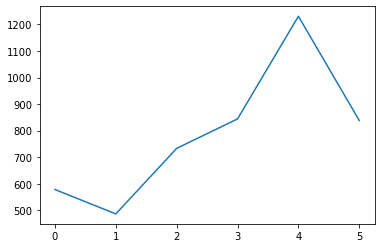

In [20]:
plt.plot(NROUNDS)

<AxesSubplot:>

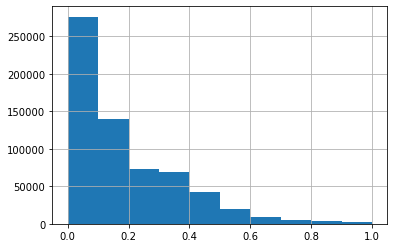

In [21]:
OOF.loc[OOF.icount==0,'ypred'].hist()

In [22]:
np.sum( (OOF.loc[OOF.target.notnull(),'target'].values - OOF.loc[OOF.target.notnull(),'ypred'].values)**2 ) / OOF['sku'].nunique()

0.23533233354922242

In [23]:
PRED = OOF.loc[OOF.icount==0].groupby('sku')['ypred'].agg('mean').reset_index()
PRED['ypred'] = PRED['ypred'].clip(0,1)
PRED

,sku,ypred
0,0,0.000902
1,1,0.135494
2,3,0.027868
3,4,0.587497
4,5,0.091247
...,...,...
639346,660911,0.096204
639347,660912,0.211643
639348,660913,0.170529
639349,660914,0.329399


In [24]:
val = VAL.copy()
for i in range(30):
    val[i] = 1. / 30

for i in range(1,7):
    val[i] = (1.0/(i+1))*val[['sku']].merge(PRED, on='sku', how='left')['ypred'].values
    val[i] = val[i].fillna(1/30)
    val[i] = val[i].clip(0,1)
val[0] = val[1]/2
    
for i in range(1,30):
    val[i] = (val[i-1] + val[i] ).clip(0,1)
val[29] = 1.

for i in range(29,0,-1):
    val[i] = val[i] - val[i-1]
    val[i] = val[i].clip(0,1)

print( metric( ytrue, val ), metric_at( ytrue, val, 0 ) )

4.096876366869448 0.036361868225524646


In [25]:
val.head(20)

dcount,sku,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,0.000225,0.000451,0.000301,0.000225,0.000180,0.000150,0.000129,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.265005
1,1,0.033874,0.067747,0.045165,0.033874,0.027099,0.022582,0.019356,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.016970
2,3,0.006967,0.013934,0.009289,0.006967,0.005574,0.004645,0.003981,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.215310
3,4,0.146874,0.293748,0.195832,0.146874,0.117499,0.097916,0.001255,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.022812,0.045624,0.030416,0.022812,0.018249,0.015208,0.013035,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.098511
5,6,0.067204,0.134409,0.089606,0.067204,0.053764,0.044803,0.038403,0.033333,0.033333,...,0.033333,0.033333,0.004607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7,0.011763,0.023526,0.015684,0.011763,0.009411,0.007842,0.006722,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.179955
7,9,0.107829,0.215658,0.143772,0.107829,0.086263,0.071886,0.061617,0.033333,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,10,0.077300,0.154599,0.103066,0.077300,0.061840,0.051533,0.044171,0.033333,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,11,0.022519,0.045038,0.030025,0.022519,0.018015,0.015013,0.012868,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.100671


<AxesSubplot:xlabel='dcount'>

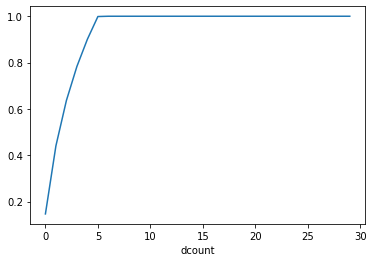

In [26]:
val.loc[3,range(30)].cumsum().plot()

<AxesSubplot:xlabel='dcount'>

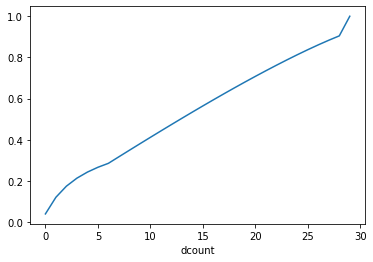

In [27]:
val.loc[:,range(30)].cumsum(1).mean().plot()

In [28]:
val.to_csv('validation-day-1-2-B.csv', index=False)

# Check metric of ensemble day1 and day2 solutions

In [29]:
val1 = pd.read_csv('validation-day-1-B.csv').sort_values('sku').reset_index(drop=True)
val2 = pd.read_csv('validation-day-1-2-B.csv').sort_values('sku').reset_index(drop=True)
val1.shape, val2.shape

((576783, 31), (576783, 31))

In [30]:
val1.head()

,sku,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,0.000852,0.000426,0.000284,0.000213,0.000170,0.000142,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.231247
1,1,0.065253,0.032627,0.021751,0.016313,0.013051,0.010876,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.073462
2,3,0.011033,0.005517,0.003678,0.002758,0.002207,0.001839,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.206302
3,4,0.393693,0.196847,0.131231,0.098423,0.078739,0.065616,0.033333,0.002118,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.046046,0.023023,0.015349,0.011511,0.009209,0.007674,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.120522


In [31]:
val2.head()

,sku,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,0.000225,0.000451,0.000301,0.000225,0.000180,0.000150,0.000129,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.265005
1,1,0.033874,0.067747,0.045165,0.033874,0.027099,0.022582,0.019356,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.016970
2,3,0.006967,0.013934,0.009289,0.006967,0.005574,0.004645,0.003981,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.215310
3,4,0.146874,0.293749,0.195832,0.146874,0.117499,0.097916,0.001255,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.022812,0.045624,0.030416,0.022812,0.018249,0.015208,0.013035,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.098511


In [32]:
val = VAL.copy()

val[0] = val1[str(0)].values**0.25 * val2[str(0)].values**0.75
val[1] = val1[str(1)].values**0.75 * val2[str(1)].values**0.25

for i in range(2,30):
    val[i] = val1[str(i)].values**0.5 * val2[str(i)].values**0.50
    
for i in range(28,-1,-1):
    val[i] = val[i].values*0.60 + val[i+1].values*0.40
for i in range(1,30):
    val[i] = val[i].values*0.95 + val[i-1].values*0.05

    
for i in range(1,30):
    val[i] = (val[i-1] + val[i] ).clip(0,1)
        
for i in range(29,0,-1):
    val[i] = val[i] - val[i-1]
    val[i] = val[i].clip(0,1)

print( metric( ytrue, val ), metric_at( ytrue, val, 0 ) )

4.065376328733227 0.03354944948713696


# Now train on 100% of trainset

In [15]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

train.shape

(37660279, 20)


(37660279, 23)

In [16]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1).fillna(0)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2).fillna(0)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3).fillna(0)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4).fillna(0)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5).fillna(0)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6).fillna(0)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7).fillna(0)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8).fillna(0)
train['sell_lag_9'] = train['sell_lag_8'] + train.groupby('sku')['sell_true'].shift(9).fillna(0)
train['sell_lag_10'] = train['sell_lag_9'] + train.groupby('sku')['sell_true'].shift(10).fillna(0)
train['sell_lag_11'] = train['sell_lag_10'] + train.groupby('sku')['sell_true'].shift(11).fillna(0)
train['sell_lag_12'] = train['sell_lag_11'] + train.groupby('sku')['sell_true'].shift(12).fillna(0)
train['sell_lag_13'] = train['sell_lag_12'] + train.groupby('sku')['sell_true'].shift(13).fillna(0)
train['sell_lag_14'] = train['sell_lag_13'] + train.groupby('sku')['sell_true'].shift(14).fillna(0)

train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(1)) #/ (train['current_price']+1)
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(2)) #/ (train['current_price']+1)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(3)) #/ (train['current_price']+1)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(4)) #/ (train['current_price']+1)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(5)) #/ (train['current_price']+1)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(6)) #/ (train['current_price']+1)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(7)) #/ (train['current_price']+1)

train['act_lag_1'] = train.groupby('sku')['minutes_active'].shift(1).bfill()
train['act_lag_2'] = train.groupby('sku')['minutes_active'].shift(2).bfill()
train['act_lag_3'] = train.groupby('sku')['minutes_active'].shift(3).bfill()
train['act_lag_4'] = train.groupby('sku')['minutes_active'].shift(4).bfill()
train['act_lag_5'] = train.groupby('sku')['minutes_active'].shift(5).bfill()
train['act_lag_6'] = train.groupby('sku')['minutes_active'].shift(6).bfill()
train['act_lag_7'] = train.groupby('sku')['minutes_active'].shift(7).bfill()

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1).bfill()

train['sold_quantity_log'] = np.log1p( train['sold_quantity'] )
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1).fillna(0)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2).fillna(0)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3).fillna(0)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4).fillna(0)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5).fillna(0)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6).fillna(0)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7).fillna(0)

CPU times: user 1min 13s, sys: 15.1 s, total: 1min 28s
Wall time: 1min 28s


<AxesSubplot:>

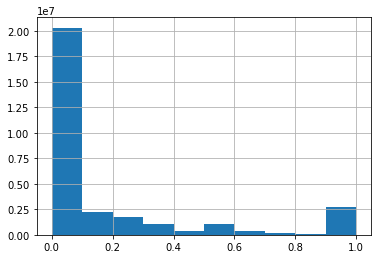

In [17]:
train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)
train['target0'] = train.groupby('sku')['target'].shift(-1)
train['target1'] = train.groupby('sku')['target'].shift(-2)
train['target'] = (train['target0'] + train['target1']).clip(0, 1)
train['target'].hist()

In [18]:
import xgboost as xgb

params = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.50,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': 0.5,
    'tree_method': 'gpu_hist',
    'verbosity': 1,
}

MODELS = []
NROUNDS = []
OOF = pd.DataFrame()
for fold in [6,5,4,3,2,0]:
    
    ind = (train.icount >fold)&(train.target.notnull())&(train.sell_lag_1.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()
    if fold>0:
        ind = (train.icount<=fold)&(train.target.notnull())
        dvalid = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()

    if fold>0:
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=3000,#np.mean(NROUNDS),
            evals=[(dvalid,'valid')],
            early_stopping_rounds=33,
            verbose_eval=100,
            ) ; gc.collect()
        NROUNDS.append(model.best_iteration)
    else:
        nround = int(np.mean(NROUNDS[-4:])+15)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=nround,
            #evals=[(dvalid,'valid')],
            #early_stopping_rounds=30,
            #verbose_eval=100,
            ) ; gc.collect()
        NROUNDS.append(nround)
    MODELS.append(model)
    
    ind = (train.icount==fold)
    tmp = train.loc[ind].copy()
    dtest = xgb.DMatrix( tmp[features], label=tmp['target'] ) ; gc.collect()
    tmp = tmp.reset_index(drop=True)
    
    ypred = 1*MODELS[0].predict(dtest)
    N =1
    SN = 1
    if len(MODELS)>1:
        for m in MODELS[1:]:
            ypred += (N*m.predict(dtest))
            SN+=N
        ypred /= SN#len(MODELS)
    
    tmp['ypred'] = np.clip(ypred,0,1)
    
    if fold>0:
        print(fold,  np.sum( (tmp.loc[tmp.target.notnull(),'target'].values - tmp.loc[tmp.target.notnull(),'ypred'].values)**2 ) / tmp['sku'].nunique(), np.mean(NROUNDS) )
    
    OOF = OOF.append(tmp)

OOF = OOF.sort_values(['sku','date']).reset_index(drop=True)
OOF.head()

6 25303839
[0]	valid-rmse:0.42892
[100]	valid-rmse:0.24497
[200]	valid-rmse:0.24316
[300]	valid-rmse:0.24263
[400]	valid-rmse:0.24244
[500]	valid-rmse:0.24233
[600]	valid-rmse:0.24226
[700]	valid-rmse:0.24222
[800]	valid-rmse:0.24219
[900]	valid-rmse:0.24217
[915]	valid-rmse:0.24217
6 0.04696674198888055 882.0
5 25797763
[0]	valid-rmse:0.42808
[100]	valid-rmse:0.24632
[200]	valid-rmse:0.24454
[300]	valid-rmse:0.24407
[400]	valid-rmse:0.24390
[500]	valid-rmse:0.24380
[600]	valid-rmse:0.24375
[700]	valid-rmse:0.24372
[800]	valid-rmse:0.24365
[834]	valid-rmse:0.24366
5 0.0447967367022588 842.0
4 26291687
[0]	valid-rmse:0.42597
[100]	valid-rmse:0.25005
[200]	valid-rmse:0.24837
[300]	valid-rmse:0.24803
[400]	valid-rmse:0.24788
[500]	valid-rmse:0.24779
[600]	valid-rmse:0.24775
[608]	valid-rmse:0.24774
4 0.04780498858708106 753.0
3 26785611
[0]	valid-rmse:0.42417
[100]	valid-rmse:0.25367
[200]	valid-rmse:0.25207
[300]	valid-rmse:0.25172
[400]	valid-rmse:0.25158
[500]	valid-rmse:0.25148
[542]	

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,target_stock,...,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,target,target0,target1,ypred
0,0,2021-03-25,2,179.990005,0,0,0,0,1440.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.877887
1,0,2021-03-26,0,179.990005,0,0,0,0,1440.0,1.0,...,4.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.702898
2,0,2021-03-27,1,179.990005,0,0,0,0,1440.0,1.0,...,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.726936
3,0,2021-03-28,0,179.990005,0,0,0,0,1440.0,1.0,...,0.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.638172
4,0,2021-03-29,0,179.990005,0,0,0,0,1440.0,1.0,...,1.0,0.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.566562


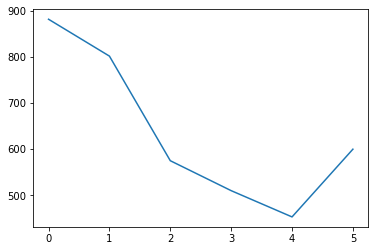

In [19]:
plt.plot(NROUNDS)

In [20]:
PRED = OOF.loc[OOF.icount==0].groupby('sku')['ypred'].agg('mean').reset_index()
PRED['ypred'] = PRED['ypred'].clip(0,1)
PRED

,sku,ypred
0,0,0.402885
1,1,0.099376
2,2,0.069480
3,3,0.159312
4,4,0.160531
...,...,...
660911,660911,0.175990
660912,660912,0.226848
660913,660913,0.140572
660914,660914,0.076906


In [21]:
test = pd.read_csv('../input/test_data.csv')
print( test.shape, test.sku.nunique() )
test = test.merge( PRED, on='sku', how='left' )
test.head()

(551472, 2) 551472


,sku,target_stock,ypred
0,464801,3,0.142977
1,645793,4,0.117759
2,99516,8,0.568849
3,538100,8,0.303938
4,557191,10,0.122591


(551472, 30)


<AxesSubplot:>

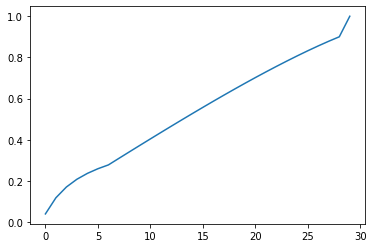

In [22]:
sub = pd.read_csv('../input/sample_submission.csv', header=None)
for i in range(30):
    sub[i] = 1. / 30
sub[29] = 1.
print( sub.shape )

for i in range(1,7):
    sub[i] = (1.0/(i+1))*test['ypred'].values
    sub[i] = sub[i].fillna(1/30)
    sub[i] = sub[i].clip(0,1)
sub[0] = sub[1]/2
   
    
for i in range(1,30):
    sub[i] = (sub[i-1] + sub[i] ).clip(0,1)

for i in range(29,0,-1):
    sub[i] = sub[i] - sub[i-1]
    sub[i] = sub[i].clip(0,1)

sub.loc[:,range(30)].cumsum(1).mean().plot()

In [23]:
sub.head(40)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.035744,0.071488,0.047659,0.035744,0.028595,0.023829,0.020425,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.003181
1,0.029440,0.058879,0.039253,0.029440,0.023552,0.019626,0.016823,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.049654
2,0.142212,0.284425,0.189616,0.142212,0.113770,0.094808,0.032956,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.075985,0.151969,0.101313,0.075985,0.060788,0.050656,0.043420,0.033333,0.033333,0.033333,...,0.006552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.030648,0.061296,0.040864,0.030648,0.024518,0.020432,0.017513,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.040748
5,0.173520,0.347040,0.231360,0.173520,0.074560,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.098203,0.196406,0.130937,0.098203,0.078562,0.065469,0.056116,0.033333,0.033333,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.011109,0.022217,0.014811,0.011109,0.008887,0.007406,0.006348,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.184781
8,0.045090,0.090181,0.060120,0.045090,0.036072,0.030060,0.025766,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.000953,0.000000,0.000000
9,0.001310,0.002620,0.001747,0.001310,0.001048,0.000873,0.000749,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.257011


In [24]:
sub.to_csv('submission-day-1-2-B.csv', index=False, header=None, float_format='%.4f')
# 3.9709

# Check correlation of day1 and day2 solutions

In [25]:
sub0 = pd.read_csv('submission-day-1-B.csv', header=None)
sub1 = pd.read_csv('submission-day-1-2-B.csv', header=None)
sub0.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0683,0.0342,0.0228,0.0171,0.0137,0.0114,0.0333,0.0333,0.0333,0.0333,...,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0659
1,0.0579,0.0290,0.0193,0.0145,0.0116,0.0097,0.0333,0.0333,0.0333,0.0333,...,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0915
2,0.3300,0.1650,0.1100,0.0825,0.0660,0.0550,0.0333,0.0333,0.0333,0.0333,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.1564,0.0782,0.0521,0.0391,0.0313,0.0261,0.0333,0.0333,0.0333,0.0333,...,0.0333,0.0333,0.0333,0.0333,0.0169,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0595,0.0298,0.0198,0.0149,0.0119,0.0099,0.0333,0.0333,0.0333,0.0333,...,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0875


In [26]:
np.corrcoef( sub0.loc[:,range(30)].values.flatten(), sub1.loc[:,range(30)].values.flatten() )[0,1]

0.7962857852303304

In [27]:
for i in range(30):
    print( i, np.corrcoef( sub0.loc[:,i].values.flatten(), sub1.loc[:,i].values.flatten() )[0,1] )

0 0.9811385898165185
1 0.9782658795414366
2 0.8995116584646262
3 0.9361475385475743
4 0.9701007609689608
5 0.9486486561075629
6 0.17063160062280747
7 0.8287958391582945
8 0.8232274594196463
9 0.8190278452069347
10 0.8147514613387941
11 0.812460553417789
12 0.8102971243392003
13 0.8078062312755261
14 0.8049456099608825
15 0.8023039155046572
16 0.800946099825226
17 0.800292876825603
18 0.7980690855621103
19 0.7972601203545322
20 0.7981510088398511
21 0.8023850782620094
22 0.8089756579453549
23 0.8183137520452514
24 0.8290972311271493
25 0.8370470341726365
26 0.8427119109850267
27 0.8495100116902163
28 0.858472944414229
29 0.9780222366939243
